In [2]:
df = spark.read.csv("Crop_recommendation.csv", header=True, inferSchema=True)
print("Dataset Loaded Successfully!")
df.printSchema()
df.show(5)


Dataset Loaded Successfully!
root
 |-- N: integer (nullable = true)
 |-- P: integer (nullable = true)
 |-- K: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- ph: double (nullable = true)
 |-- rainfall: double (nullable = true)
 |-- label: string (nullable = true)

+---+---+---+-----------+-----------+-----------------+-----------+-----+
|  N|  P|  K|temperature|   humidity|               ph|   rainfall|label|
+---+---+---+-----------+-----------+-----------------+-----------+-----+
| 90| 42| 43|20.87974371|82.00274423|6.502985292000001|202.9355362| rice|
| 85| 58| 41|21.77046169|80.31964408|      7.038096361|226.6555374| rice|
| 60| 55| 44|23.00445915| 82.3207629|      7.840207144|263.9642476| rice|
| 74| 35| 40|26.49109635|80.15836264|      6.980400905|242.8640342| rice|
| 78| 42| 42|20.13017482|81.60487287|      7.628472891|262.7173405| rice|
+---+---+---+-----------+-----------+-----------------+-----------+-----+
onl

In [3]:
from pyspark.sql.functions import col
missing = df.select([col(c).isNull().alias(c) for c in df.columns])
missing.show()
df_clean = df.dropna()
print("Rows before:", df.count(), " | Rows after cleaning:", df_clean.count())


+-----+-----+-----+-----------+--------+-----+--------+-----+
|    N|    P|    K|temperature|humidity|   ph|rainfall|label|
+-----+-----+-----+-----------+--------+-----+--------+-----+
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|false|false|      false|   false|false|   false|false|
|false|f

In [5]:
!pip install matplotlib seaborn


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 8.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.1 MB 7.8 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 7.3 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.1 MB 5.4 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 4.7 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 4.2 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 4.3 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.3 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.2 MB/s eta 0:00:00

   ----------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


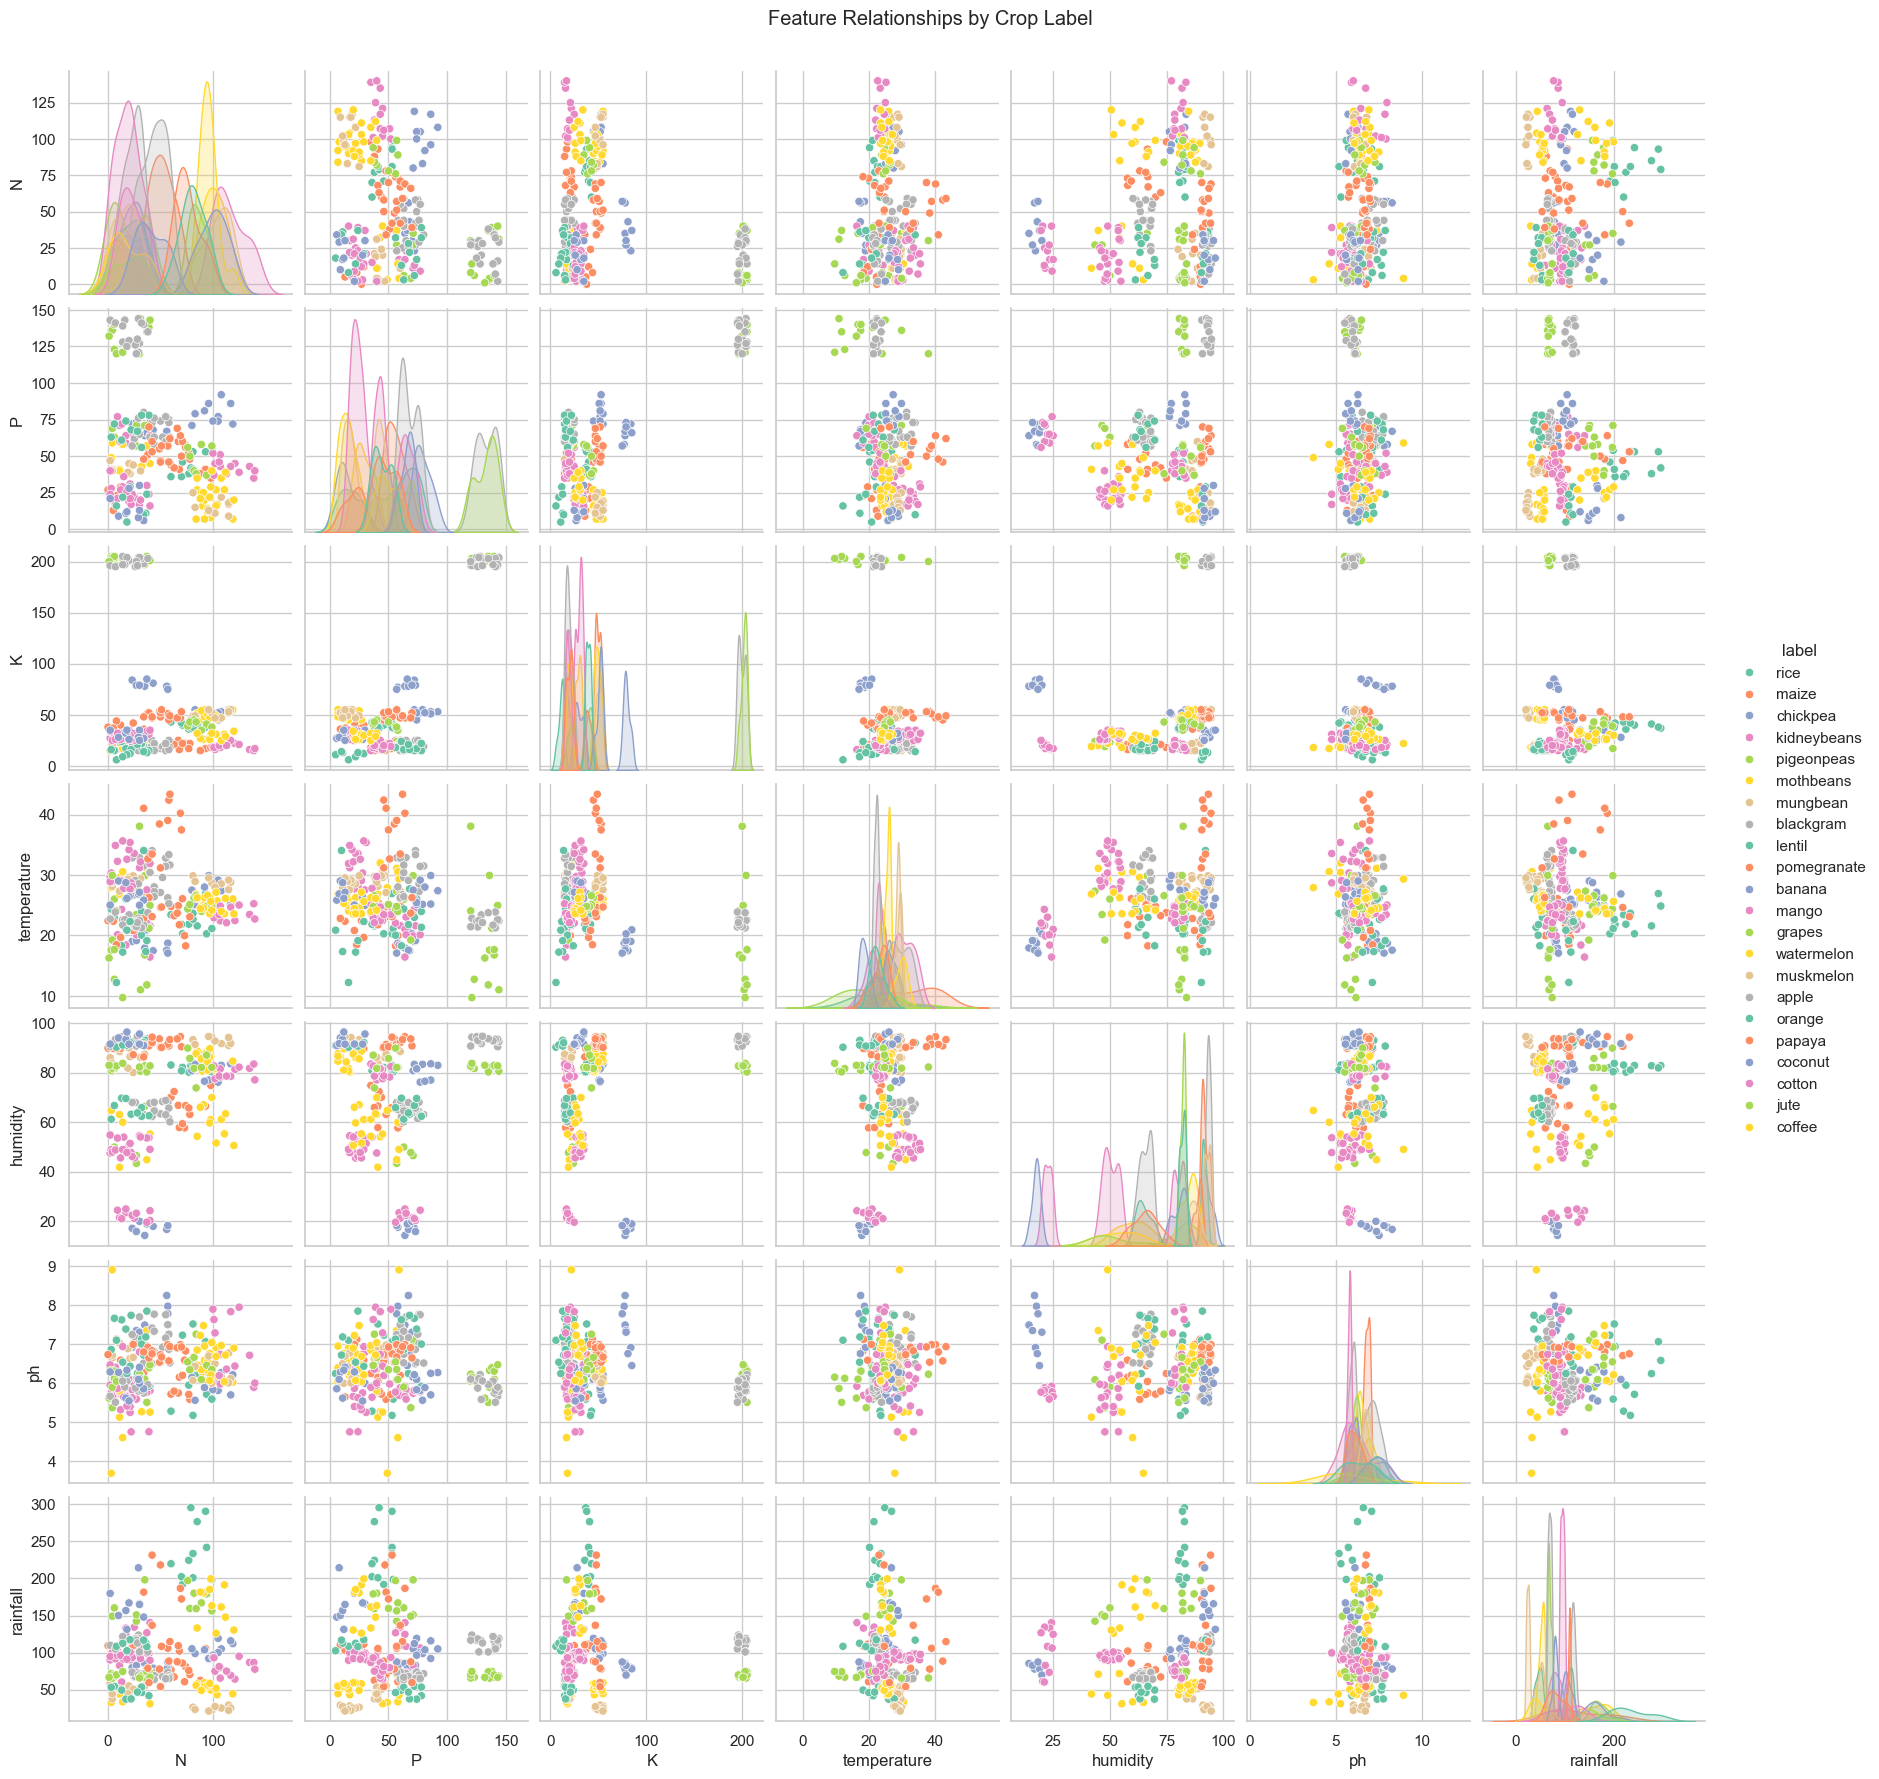

In [9]:
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()  
sns.pairplot(pandas_df, vars=["N", "P", "K", "temperature", "humidity", "ph", "rainfall"], hue="label", palette="Set2")
plt.suptitle("Feature Relationships by Crop Label", y=1.02)
plt.show()


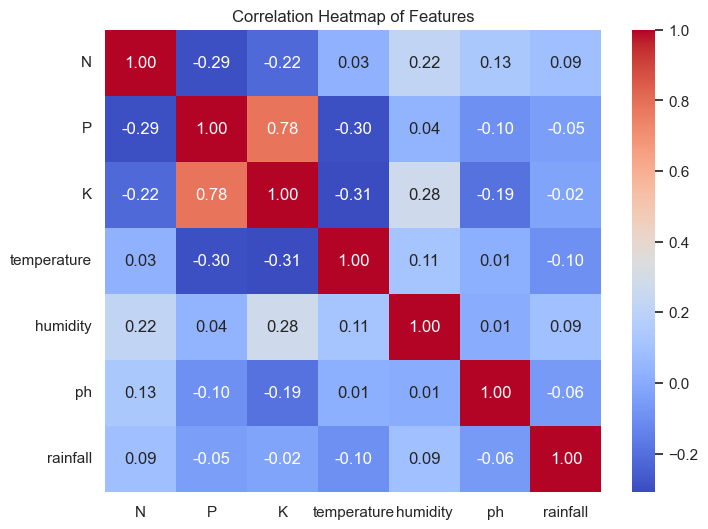

In [10]:
corr = pandas_df[["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


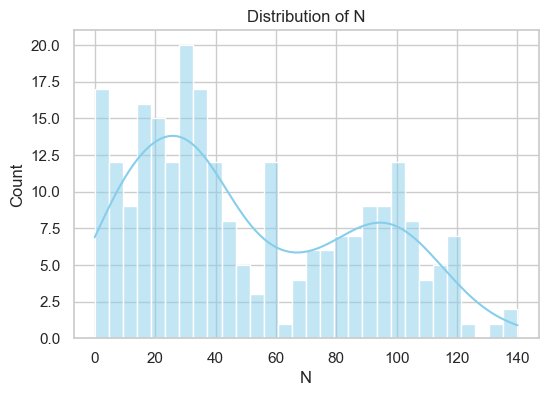

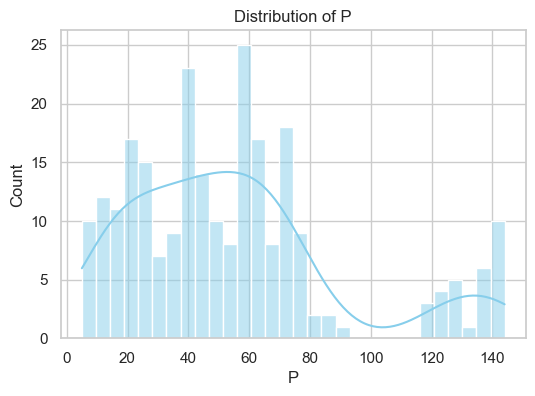

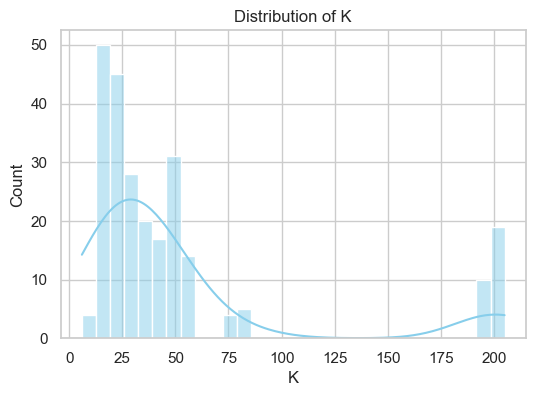

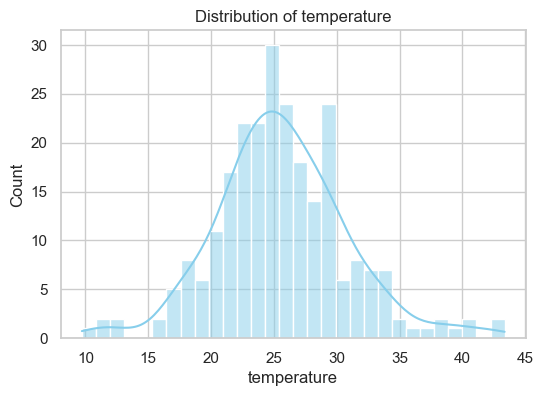

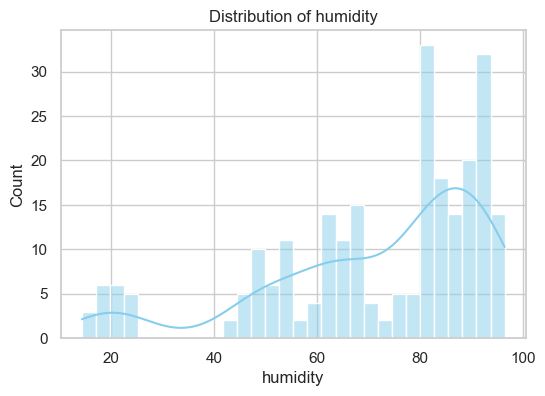

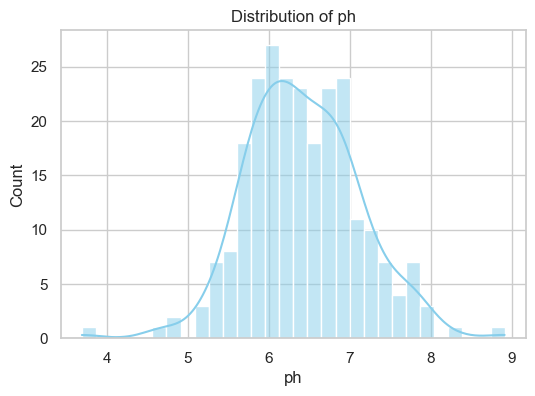

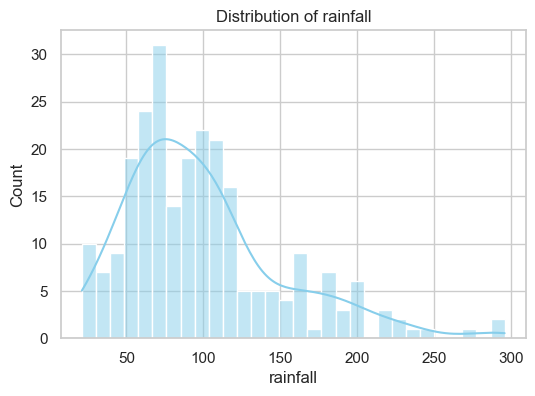

In [11]:
features = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(pandas_df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


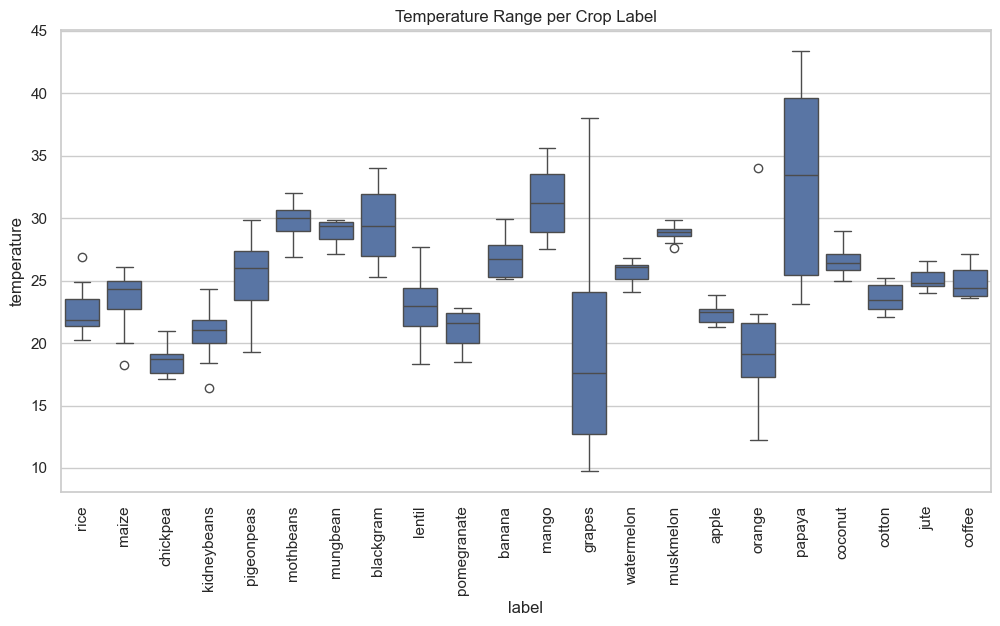

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=pandas_df, x="label", y="temperature")
plt.title("Temperature Range per Crop Label")
plt.xticks(rotation=90)
plt.show()


C:\Users\BHAVANA REDDY\AppData\Local\Temp\ipykernel_23064\1805092564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="label", order=pandas_df['label'].value_counts().index, palette="Set3")


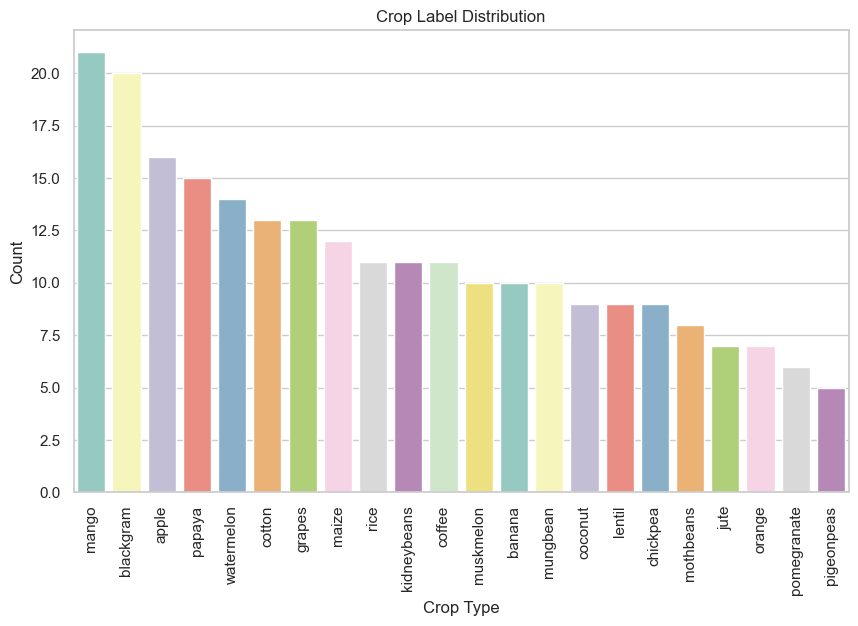

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(data=pandas_df, x="label", order=pandas_df['label'].value_counts().index, palette="Set3")
plt.xticks(rotation=90)
plt.title("Crop Label Distribution")
plt.xlabel("Crop Type")
plt.ylabel("Count")
plt.show()


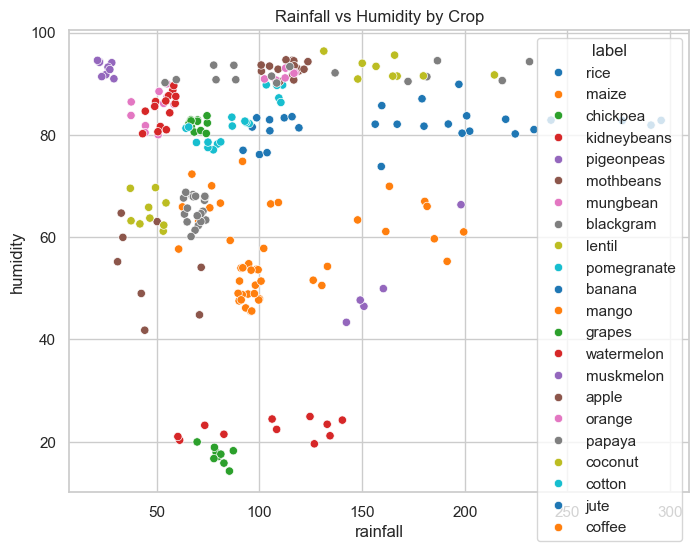

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pandas_df, x="rainfall", y="humidity", hue="label", palette="tab10")
plt.title("Rainfall vs Humidity by Crop")
plt.show()


In [17]:
# Code 7: Feature Vectorization
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Convert label to numeric index
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
df_indexed = indexer.fit(df).transform(df)

# Assemble all numeric features into one vector column
feature_cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_indexed)

df_features.select("features", "labelIndex").show(5, truncate=False)


+----------------------------------------------------------------------+----------+
|features                                                              |labelIndex|
+----------------------------------------------------------------------+----------+
|[90.0,42.0,43.0,20.87974371,82.00274423,6.502985292000001,202.9355362]|20.0      |
|[85.0,58.0,41.0,21.77046169,80.31964408,7.038096361,226.6555374]      |20.0      |
|[60.0,55.0,44.0,23.00445915,82.3207629,7.840207144,263.9642476]       |20.0      |
|[74.0,35.0,40.0,26.49109635,80.15836264,6.980400905,242.8640342]      |20.0      |
|[78.0,42.0,42.0,20.13017482,81.60487287,7.628472891,262.7173405]      |20.0      |
+----------------------------------------------------------------------+----------+
only showing top 5 rows


In [18]:
# Code 8: Train-Test Split and Decision Tree Training
from pyspark.ml.classification import DecisionTreeClassifier

train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
dt_model = dt.fit(train_data)

print("Decision Tree Model Trained Successfully!")


Decision Tree Model Trained Successfully!


In [19]:
# Code 9: Evaluate Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Model Accuracy:", round(accuracy * 100, 2), "%")

# Display sample predictions
predictions.select("labelIndex", "prediction", "features").show(10, truncate=False)


Model Accuracy: 39.23 %
+----------+----------+----------------------------------------------------------------------+
|labelIndex|prediction|features                                                              |
+----------+----------+----------------------------------------------------------------------+
|12.0      |18.0      |[0.0,17.0,30.0,35.47478322,47.97230503,6.279133738,97.79072474]       |
|4.0       |19.0      |[0.0,19.0,33.0,27.1326009,95.23797989,6.234458417000001,204.7206567]  |
|16.0      |19.0      |[0.0,23.0,15.0,22.56664172,93.37488907,7.598729065,109.8585753]       |
|12.0      |18.0      |[0.0,36.0,26.0,34.13072188,51.25786185,5.101206389,96.38808001]       |
|10.0      |18.0      |[0.0,67.0,22.0,29.82112112,69.4073209,6.5937983870000005,51.56461082] |
|0.0       |0.0       |[0.0,123.0,205.0,22.02775403,92.96129462,5.790993052,121.1349176]     |
|4.0       |19.0      |[1.0,12.0,30.0,27.754298,95.94643831,5.56222383,131.09000759999998]   |
|12.0      |18.0      |[1.

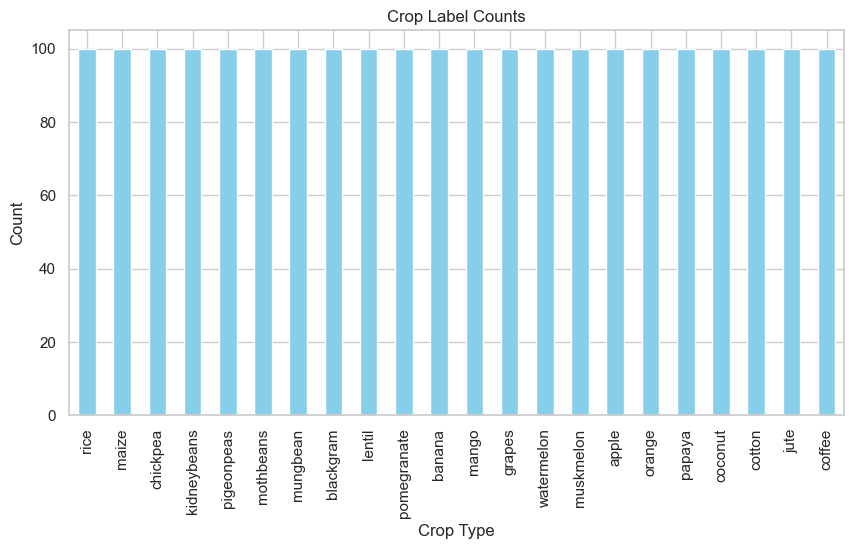

In [23]:
# Convert to pandas for visualization
pandas_df = df.toPandas()

# Count of each crop label
plt.figure(figsize=(10,5))
pandas_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Crop Label Counts")
plt.xlabel("Crop Type")
plt.ylabel("Count")
plt.show()


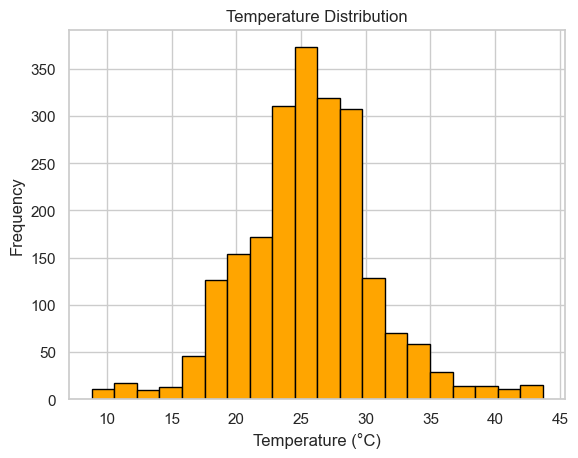

In [24]:
plt.hist(pandas_df['temperature'], bins=20, color='orange', edgecolor='black')
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()


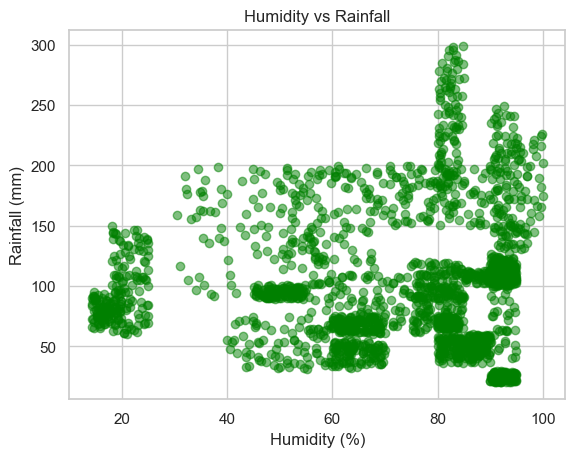

In [25]:
plt.scatter(pandas_df['humidity'], pandas_df['rainfall'], alpha=0.5, color='green')
plt.title("Humidity vs Rainfall")
plt.xlabel("Humidity (%)")
plt.ylabel("Rainfall (mm)")
plt.show()


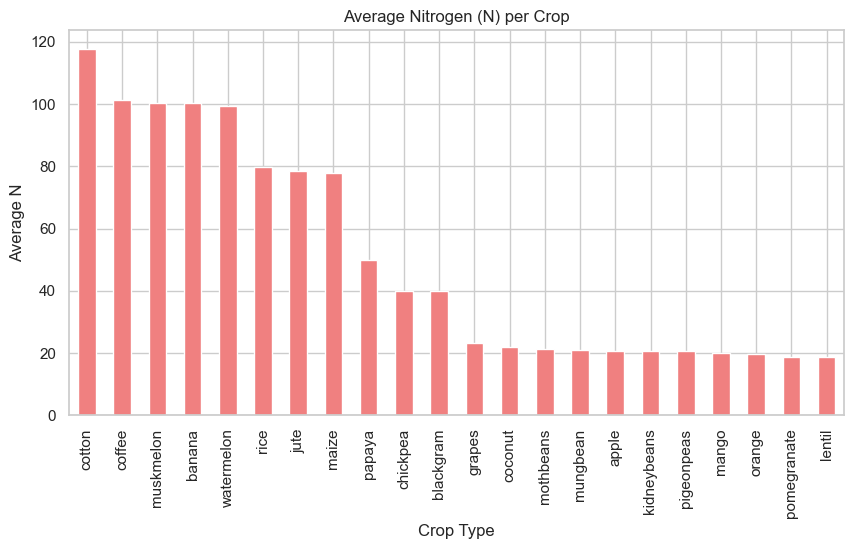

In [26]:
avg_n = pandas_df.groupby('label')['N'].mean().sort_values(ascending=False)
avg_n.plot(kind='bar', color='lightcoral', figsize=(10,5))
plt.title("Average Nitrogen (N) per Crop")
plt.xlabel("Crop Type")
plt.ylabel("Average N")
plt.show()
